In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

from tqdm import tqdm

import copy

In [ ]:
print('Loading Image ...')
img_orig = np.double(Image.open('./samsung.jpg').resize((288, 140)))[:,:,3]

plt.figure()
plt.imshow(img_orig, cmap='gray')
plt.title("original image")

In [ ]:
print('Binarize image ...')
img_mean = np.mean(img_orig)
img_binary = (+1)*(img_orig>img_mean) + (-1)*(img_orig<img_mean)
[H, W] = img_binary.shape

plt.figure()
plt.imshow(img_binary, cmap='gray')
plt.title("binary image")

Loading Image ...
(140, 288)


Text(0.5,1,'noisy image')

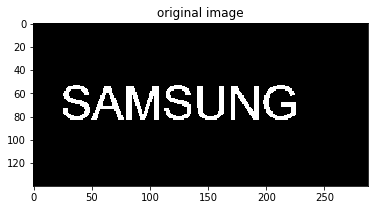

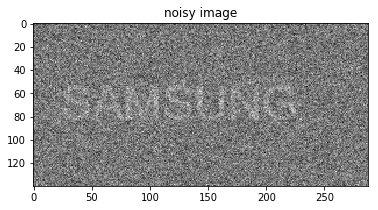

In [2]:
print('Generate noisy image ...')
sigma  = 2.0
y = img_binary + sigma*np.random.randn(H, W)

plt.figure()
plt.imshow(y, cmap='gray')
plt.title("noisy image")

100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


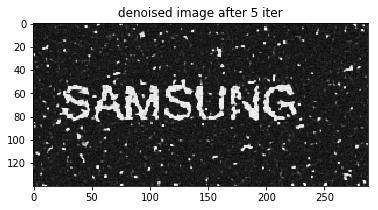

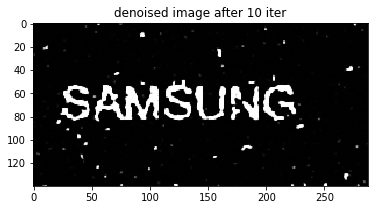

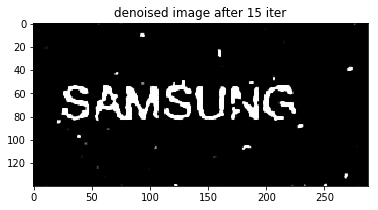

In [3]:
W_ij = 1.0
dampling_factor = 0.5
max_iter = 15

normal_pos = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2), (H, W))
normal_neg = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2), (H, W))
normal_all = normal_pos - normal_neg

mu = y

a = mu + 0.5*normal_all
prob_x_pos = sigmoid(+2*a)
prob_x_neg = sigmoid(-2*a)

for i in tqdm(range(max_iter)):
    prev_mu = copy.deepcopy(mu)
    
    for w in range(W):
        for h in range(H):
            position = H*w + h
            nbr = position + np.array([-1,1,-H,H])
            boundary_idx = [h!=0,h!=H-1,w!=0,w!=W-1]
            nbr = nbr[np.where(boundary_idx)[0]]
            xi_h, xi_w = np.unravel_index(position, (H,W), order='F')
            nbr_h, nbr_w = np.unravel_index(nbr, (H,W), order='F')
            mu[xi_h,xi_w] = (1-dampling_factor)*prev_mu[xi_h,xi_w] \
                            + dampling_factor*np.tanh(W_ij*np.sum(prev_mu[nbr_h,nbr_w]) + 0.5*normal_all[xi_h,xi_w])
    if ((i+1)%5==0):
        plt.figure()
        plt.imshow(mu, cmap='gray')
        plt.title("denoised image after %d iter" % (i+1))